In [6]:
import csv
from rdkit import Chem
from rdkit.Chem import Descriptors
import numpy as np
import os
from tqdm import tqdm

def calculate_properties(input_file, output_file):
    with open(input_file, 'r') as f:
        smiles_list = [line.strip() for line in f if line.strip()]

    with open(output_file, 'w', newline='') as csvfile:
        fieldnames = ['SMILES', 'MW', 'TPSA', 'logP', 'QED']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

        for smi in smiles_list:
            mol = Chem.MolFromSmiles(smi)
            if mol:
                mw = Descriptors.MolWt(mol)
                tpsa = Descriptors.TPSA(mol)
                logp = Descriptors.MolLogP(mol)
                qed = Descriptors.qed(mol)
                writer.writerow({'SMILES': smi, 'MW': mw, 'TPSA': tpsa, 'logP': logp, 'QED': qed})
            else:
                writer.writerow({'SMILES': smi, 'MW': None, 'TPSA': None, 'logP': None, 'QED': None})

def process_folder(input_folder, output_folder):
    """
    Process all SMILES files in the input folder and save results in the output folder.

    Args:
        input_folder (str): Path to the input folder containing SMILES files.
        output_folder (str): Path to the output folder to save CSV files.
    """
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    smi_files = [f for f in os.listdir(input_folder) if os.path.isfile(os.path.join(input_folder, f)) and f.endswith('.smi')]

    for filename in tqdm(smi_files, desc="Processing folder"):
        input_path = os.path.join(input_folder, filename)
        output_path = os.path.join(output_folder, filename.replace('.smi', '.csv'))
        calculate_properties(input_path, output_path)

# input_folder = '/Users/mac/Downloads/code/project/mol_opt/app/experiment/scaffold'
# output_folder = '/Users/mac/Downloads/code/project/mol_opt/app/experiment/opt_res_properties'
# process_folder(input_folder, output_folder)
input_f = '/Users/mac/Downloads/code/project/mol_opt/app/experiment/opt_res/unseen_logP_4_tpsa_160.smi'
output_f = '/Users/mac/Downloads/code/project/mol_opt/app/experiment/opt_res_properties/unseen_logP_4_tpsa_160.smi'
calculate_properties(input_f, output_f)

In [7]:
import pandas as pd

def calculate_gkld(file_to_target_mapping: dict) -> dict:
    """
    Calculate GKLD for a set of files based on their respective target properties.

    Parameters:
        file_to_target_mapping (dict): Dictionary where keys are filenames (CSV) and values are
dictionaries of target properties (e.g., {'logP': 2, 'QED': 0.6}).

    Returns:
        dict: GKLD values for each file and comparison, structured as {filename: {"current": gkld1, "train": gkld2, "val": gkld3}}.
    """
    results = {}

    train_file = "/Users/mac/Downloads/code/project/mol_opt/app/experiment/opt_res_properties/train_100_scaffold.csv"
    val_file = "/Users/mac/Downloads/code/project/mol_opt/app/experiment/opt_res_properties/val_100_scaffold.csv"

    for file, target_properties in tqdm(file_to_target_mapping.items(), desc="Calculating GKLD"):
        result = {}

        # Load data for the current file
        data = pd.read_csv(f'//Users/mac/Downloads/code/project/mol_opt/app/experiment/opt_res_properties/{file}')
        data_points = data[list(target_properties.keys())].values
        target_point = np.array(list(target_properties.values()))

        # Compute GKLD for the current file
        distances = np.sum((data_points - target_point) ** 2, axis=1)
        bandwidth = 0.1
        kernel = np.exp(-distances / (2 * bandwidth ** 2))
        result["current"] = np.mean(kernel)

        # Compute GKLD for the train file
        train_data = pd.read_csv(train_file)
        train_points = train_data[list(target_properties.keys())].values
        train_distances = np.sum((train_points - target_point) ** 2, axis=1)
        train_kernel = np.exp(-train_distances / (2 * bandwidth ** 2))
        result["train"] = np.mean(train_kernel)

        # Compute GKLD for the val file
        val_data = pd.read_csv(val_file)
        val_points = val_data[list(target_properties.keys())].values
        val_distances = np.sum((val_points - target_point) ** 2, axis=1)
        val_kernel = np.exp(-val_distances / (2 * bandwidth ** 2))
        result["val"] = np.mean(val_kernel)

        results[file] = result

    return results

FILE_TO_TARGET_MAPPING = {
    'train-qed-0d2-scaffold.csv': {'QED': 0.2},
    'val-logp-n4-scaffold.csv': {'logP': -4},
    'train-qed-0d4-scaffold.csv': {'QED': 0.4},
    'val-logp-n2-scaffold.csv': {'logP': -2},
    'val-qed-0d8-scaffold.csv': {'QED': 0.8},
    'train-tpsa-40-scaffold.csv': {'TPSA': 40},
    'val-logp-2-tpsa-40-scaffold.csv': {'logP': 2, 'TPSA': 40},
    'train-all-logp-300-80-3-0d7-scaffold.csv': {'logP': 3.0, 'TPSA': 80, 'QED': 0.7},
    'train-logp-2-tpsa-40-scaffold.csv': {'logP': 2, 'TPSA': 40},
    'train-logp-n4-scaffold.csv': {'logP': -4},
    'val-logp-4-scaffold.csv': {'logP': 4},
    'val-logp-4-tpsa-160-scaffold.csv': {'logP': 4, 'TPSA': 160},
    'val-qed-0d2-scaffold.csv': {'QED': 0.2},
    'val-tpsa-40-scaffold.csv': {'TPSA': 40},
    'val-logp-3-tpsa-100-scaffold.csv': {'logP': 3, 'TPSA': 100},
    'val-all-logp-250-140-2-0d6-scaffold.csv': {'logP': 2.0, 'TPSA': 140, 'QED': 0.6},
    'train-qed-0d8-scaffold.csv': {'QED': 0.8},
    'train-logp-n2-scaffold.csv': {'logP': -2},
    'val-logp-2-scaffold.csv': {'logP': 2},
    'val-qed-0d4-scaffold.csv': {'QED': 0.4},
    'val-all-logp-300-80-3-0d7-scaffold.csv': {'logP': 3.0, 'TPSA': 80, 'QED': 0.7},
    'val-qed-0d6-scaffold.csv': {'QED': 0.6},
    'train-logp-4-scaffold.csv': {'logP': 4},
    'train-tpsa-80-scaffold.csv': {'TPSA': 80},
    'train-tpsa-120-scaffold.csv': {'TPSA': 120},
    'train-tpsa-160-scaffold.csv': {'TPSA': 160},
    'train-logp-2-scaffold.csv': {'logP': 2},
    'train-qed-0d6-scaffold.csv': {'QED': 0.6},
    'val-tpsa-80-scaffold.csv': {'TPSA': 80},
    'val-tpsa-160-scaffold.csv': {'TPSA': 160},
    'train-all-logp-250-140-2-0d6-scaffold.csv': {'logP': 2.0, 'TPSA': 140, 'QED': 0.6},
    'val-tpsa-120-scaffold.csv': {'TPSA': 120},
    'train-logp-4-tpsa-160-scaffold.csv': {'logP': 4, 'TPSA': 160},
    'train-logp-3-tpsa-100-scaffold.csv': {'logP': 3, 'TPSA': 100},
    'unseen_logP_2_tpsa_40.csv': {'logP': 2, 'TPSA': 40},
    'unseen_logP_3_tpsa_100.csv': {'logP': 3, 'TPSA': 100},
    'unseen_logP_4_tpsa_160.csv': {'logP': 4, 'TPSA': 160},
}

gklb = calculate_gkld(FILE_TO_TARGET_MAPPING)
gklb

Calculating GKLD: 100%|██████████| 37/37 [00:00<00:00, 49.44it/s]


{'train-qed-0d2-scaffold.csv': {'current': 0.7745234210365622,
  'train': 0.03333628751059794,
  'val': 0.02314024925651928},
 'val-logp-n4-scaffold.csv': {'current': 0.19499806726879865,
  'train': 6.853077431773219e-86,
  'val': 4.911225987417102e-73},
 'train-qed-0d4-scaffold.csv': {'current': 0.8387209766697351,
  'train': 0.20990043599811184,
  'val': 0.16309348232306348},
 'val-logp-n2-scaffold.csv': {'current': 0.2992812650661192,
  'train': 0.009146725832160849,
  'val': 0.0013371931313570222},
 'val-qed-0d8-scaffold.csv': {'current': 0.7945198873206947,
  'train': 0.5033291233007472,
  'val': 0.4947982404706252},
 'train-tpsa-40-scaffold.csv': {'current': 0.019053425996593706,
  'train': 2.5884918087776453e-07,
  'val': 8.188701014373516e-05},
 'val-logp-2-tpsa-40-scaffold.csv': {'current': 0.006430144803115035,
  'train': 4.363592347197114e-09,
  'val': 1.677316580155046e-53},
 'train-all-logp-300-80-3-0d7-scaffold.csv': {'current': 0.0023281020367845353,
  'train': 1.1735429

In [87]:
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import numpy as np

def visualize_gkld_results(results: dict, selected_files: list, x_labels: list):
    """
    Visualize GKLD results using grouped bar charts for selected files.

    Parameters:
        results (dict): GKLD values structured as {filename: {"current": gkld1, "train": gkld2, "val": gkld3}}.
        selected_files (list): List of filenames to include in the visualization.
    """
    # 设置全局字体大小
    plt.rcParams.update({'font.size': 14})

    filtered_results = {file: results[file] for file in selected_files if file in results}

    labels = list(filtered_results.keys())
    current_values = [filtered_results[file]["current"] for file in labels]
    train_values = [filtered_results[file]["train"] for file in labels]
    val_values = [filtered_results[file]["val"] for file in labels]

    x = np.arange(len(labels))
    width = 0.25

    plt.figure(figsize=(16, 8))  # 增大图表尺寸
    plt.bar(x - width, current_values, width, label='Optimized')
    plt.bar(x, train_values, width, label='Train')
    plt.bar(x + width, val_values, width, label='Val')

    plt.xlabel('Target Properties', fontsize=20)  # 调整坐标轴标签字体大小
    plt.ylabel('GKLD', fontsize=20)
    plt.title('GKLD Comparison between Train, Val, and Optimized Group', fontsize=24)  # 调整标题字体大小
    plt.xticks(x, x_labels, fontsize=20)  # 旋转 x 轴标签
    plt.yticks(fontsize=20)  # 调整 y 轴刻度字体大小
    plt.legend(fontsize=20)  # 调整图例字体大小
    plt.tight_layout()  # 自动调整间距
    plt.show()



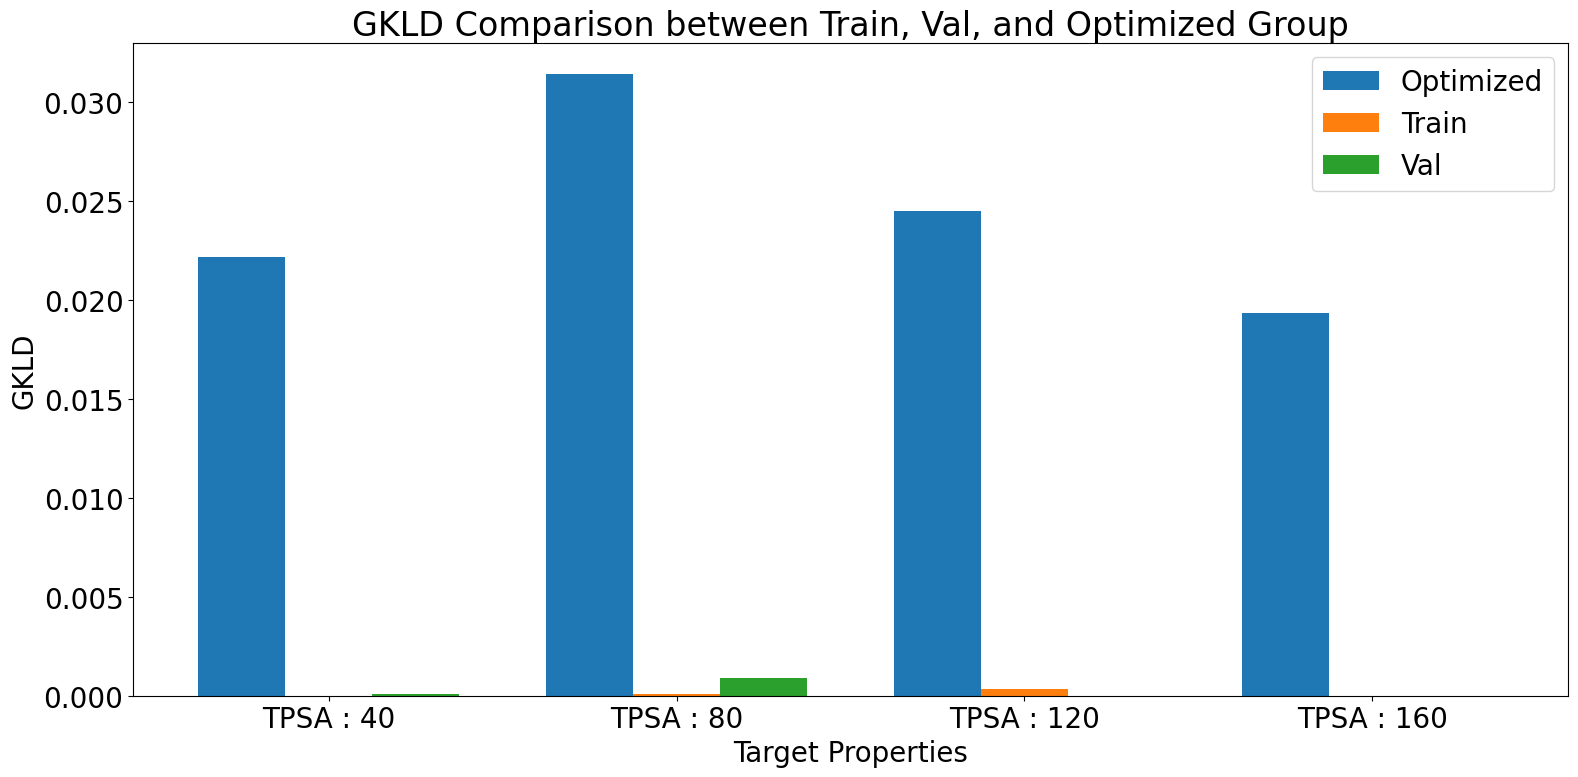

In [88]:
selected_files = [f'val-tpsa-{tpsa}-scaffold.csv' for tpsa in [40, 80, 120, 160]]
labels = [f'TPSA : {tpsa}' for tpsa in [40, 80, 120, 160]]
visualize_gkld_results(gklb, selected_files, labels)

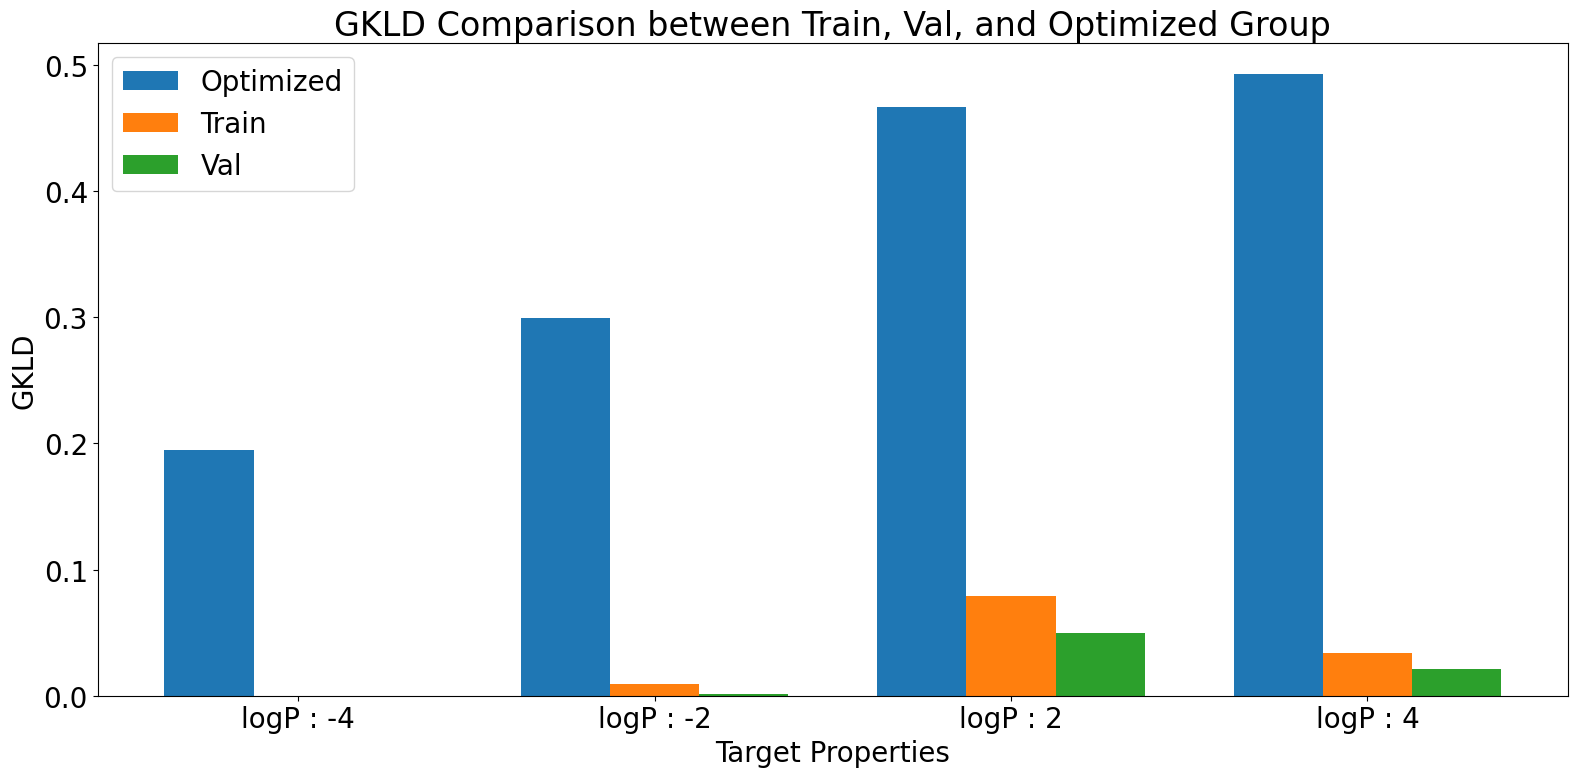

In [89]:
selected_files = [f'val-logp-{logp}-scaffold.csv' for logp in ['n4', 'n2', 2, 4]]
labels = [f'logP : {logp}' for logp in [-4, -2, 2, 4]]
visualize_gkld_results(gklb, selected_files, labels)

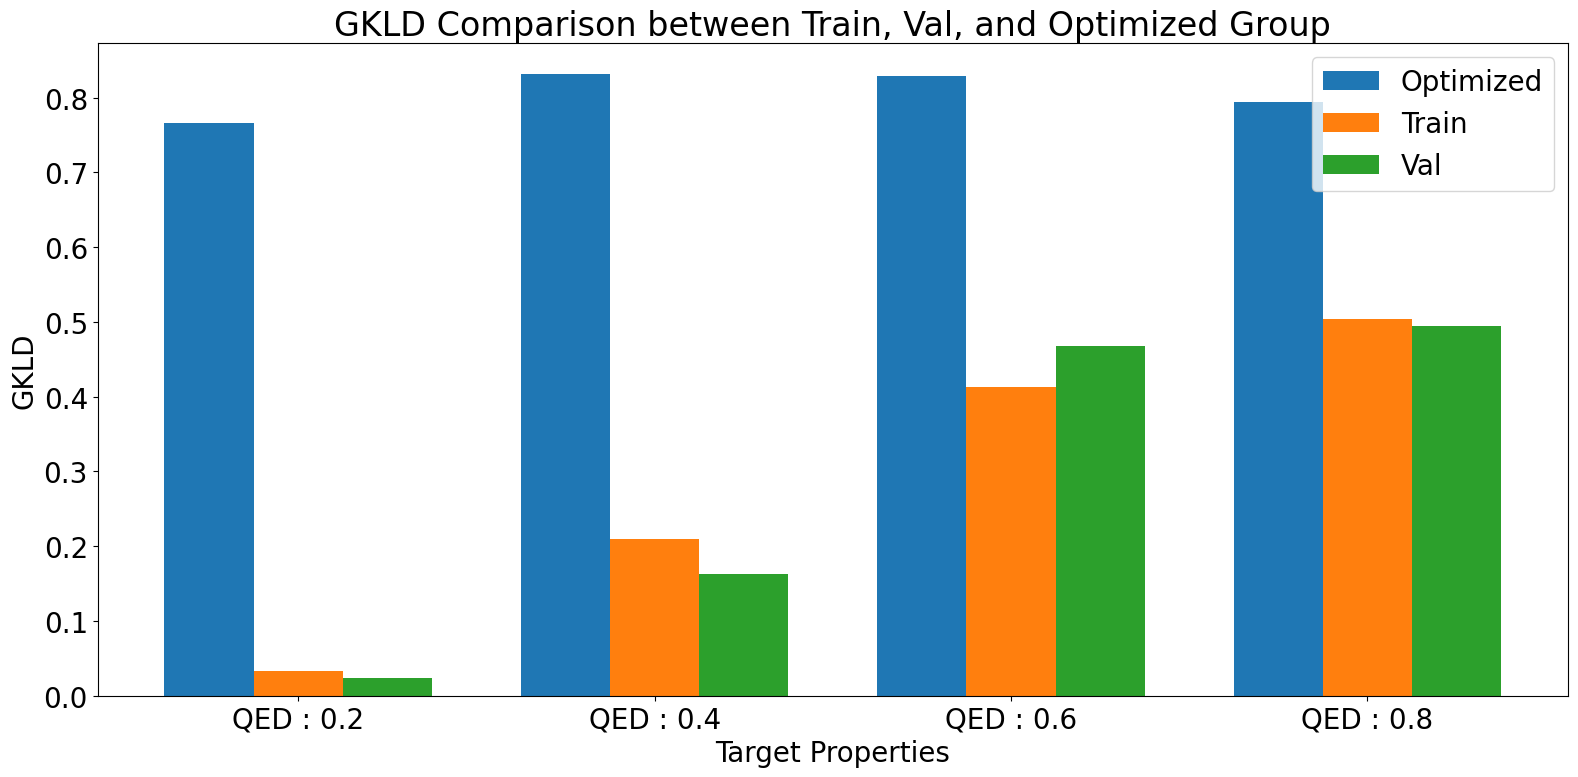

In [90]:
selected_files = [f'val-qed-{qed}-scaffold.csv' for qed in ['0d2', '0d4', '0d6', '0d8']]
labels = [f'QED : {qed}' for qed in [0.2, 0.4, 0.6, 0.8]]
visualize_gkld_results(gklb, selected_files, labels)

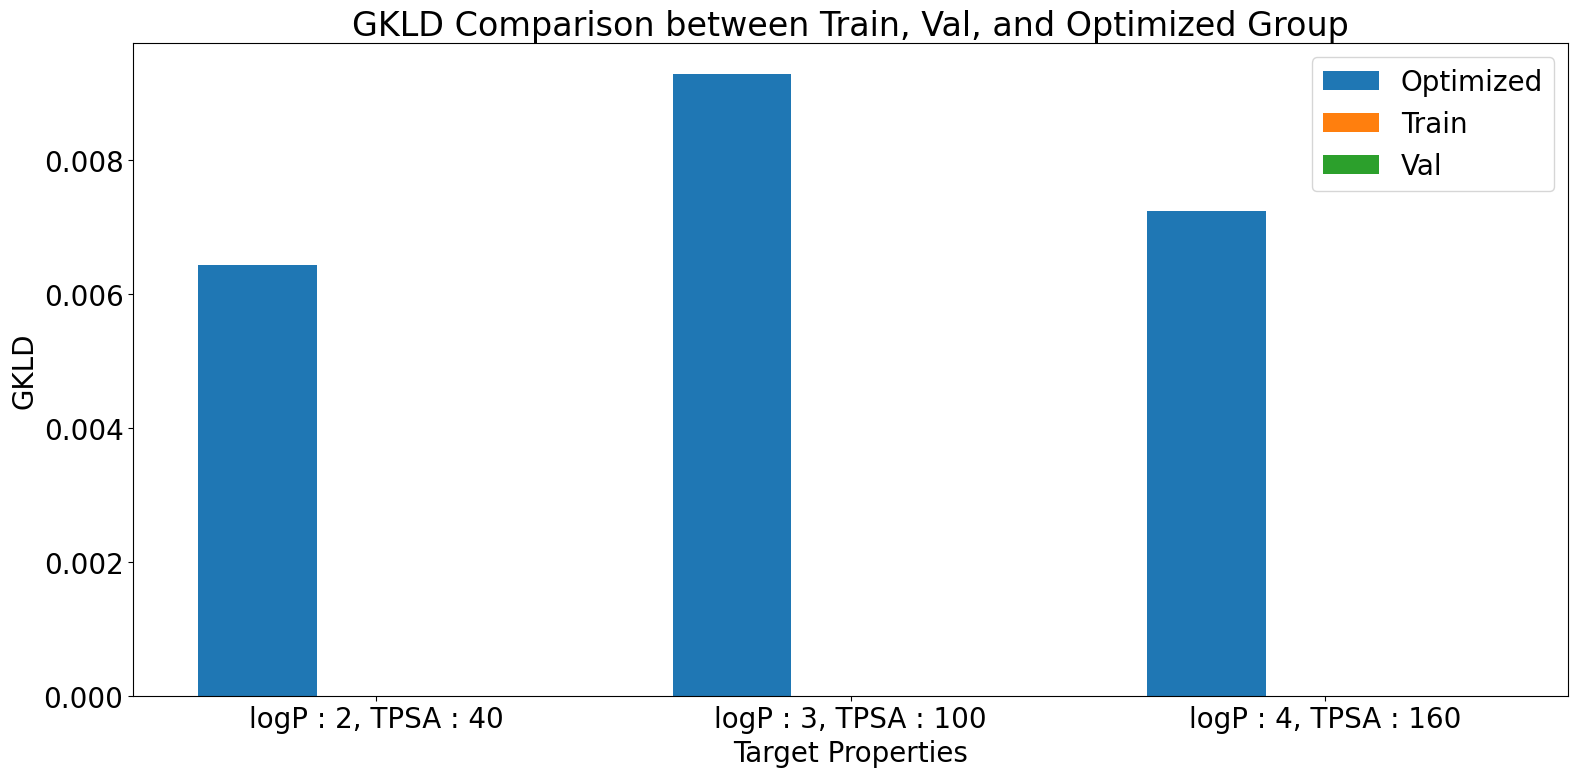

In [93]:
selected_files = ['val-logp-2-tpsa-40-scaffold.csv',
                  'val-logp-3-tpsa-100-scaffold.csv',
                  'val-logp-4-tpsa-160-scaffold.csv',
                  ]
labels = ['logP : 2, TPSA : 40',
          'logP : 3, TPSA : 100',
          'logP : 4, TPSA : 160',
          ]
visualize_gkld_results(gklb, selected_files, labels)

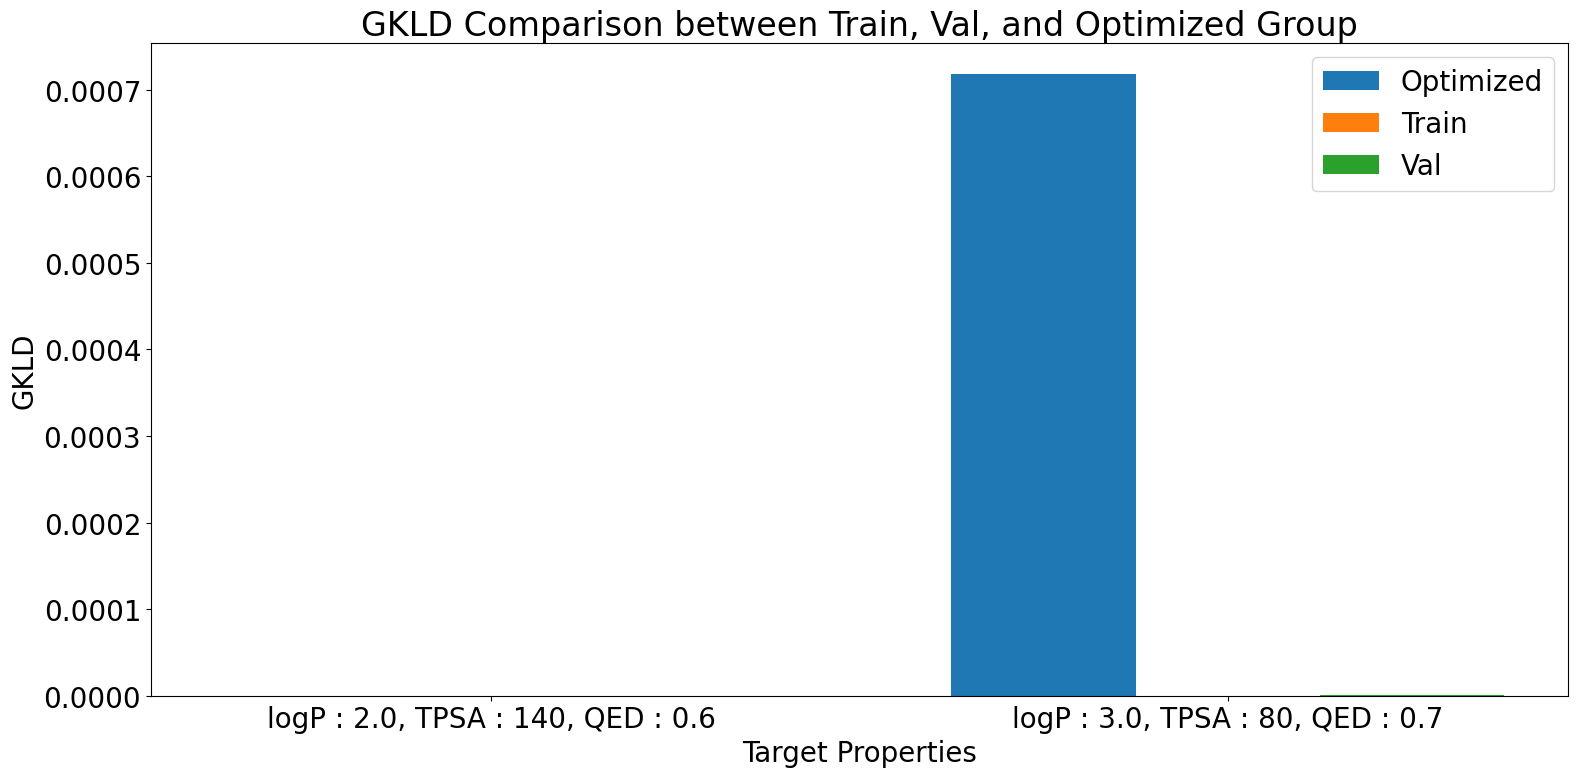

In [91]:
selected_files = ['val-all-logp-250-140-2-0d6-scaffold.csv',
                  'val-all-logp-300-80-3-0d7-scaffold.csv']
labels = ['logP : 2.0, TPSA : 140, QED : 0.6',
            'logP : 3.0, TPSA : 80, QED : 0.7']
visualize_gkld_results(gklb, selected_files, labels)

[0.006430144803115035, 0.009273970137031289, 0.007228524129822998]
[0.0038713691525337087, 0.00789232563438921, 0.003042845470489312]


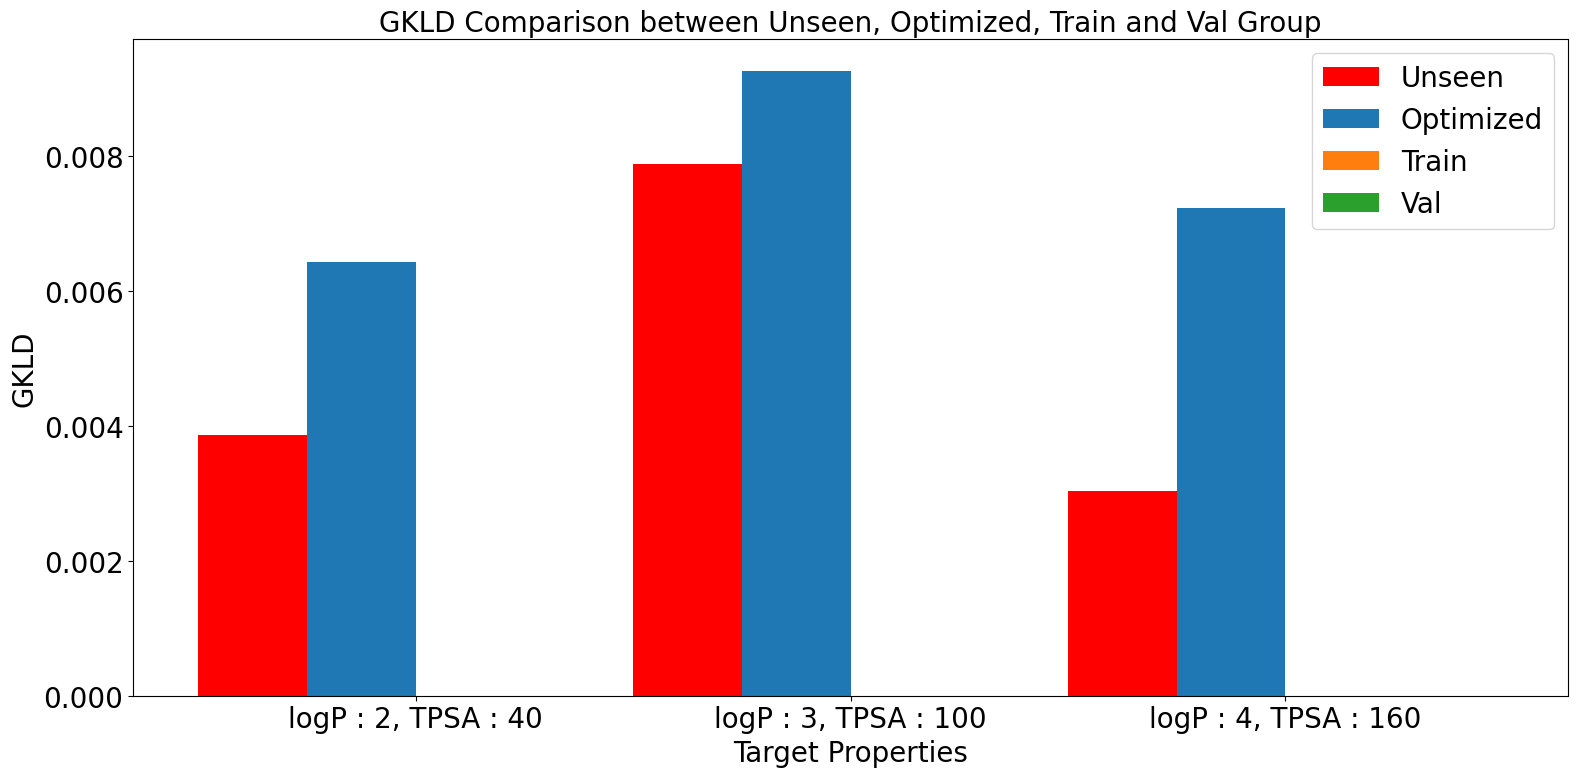

In [92]:
selected_files = ['val-logp-2-tpsa-40-scaffold.csv',
                  'val-logp-3-tpsa-100-scaffold.csv',
                  'val-logp-4-tpsa-160-scaffold.csv',
                  ]
unseen_files = [
    'unseen_logP_2_tpsa_40.csv',
    'unseen_logP_3_tpsa_100.csv',
    'unseen_logP_4_tpsa_160.csv',
]
labels = ['logP : 2, TPSA : 40',
          'logP : 3, TPSA : 100',
          'logP : 4, TPSA : 160',
          ]

# visualize_gkld_results(gklb, selected_files, labels)
results = gklb
x_labels = labels

import matplotlib.pyplot as plt

filtered_results = {file: results[file] for file in selected_files if file in results}

labels = list(filtered_results.keys())

unseen_vals = [gklb['unseen_logP_2_tpsa_40.csv']['current'], gklb['unseen_logP_3_tpsa_100.csv']['current'], gklb['unseen_logP_4_tpsa_160.csv']['current']]
current_values = [filtered_results[file]["current"] for file in labels]
train_values = [filtered_results[file]["train"] for file in labels]
val_values = [filtered_results[file]["val"] for file in labels]

print(current_values)
print(unseen_vals)


x = np.arange(len(labels))
width = 0.25

plt.figure(figsize=(16, 8))
plt.bar(x - 1.5 * width, unseen_vals, width, color='red', label='Unseen')
plt.bar(x - 0.5 * width, current_values, width, label='Optimized')
plt.bar(x + 0.5 * width, train_values, width, label='Train')
plt.bar(x + 1.5 * width, val_values, width, label='Val')

plt.xlabel('Target Properties', fontsize=20)
plt.ylabel('GKLD', fontsize=20)
plt.title('GKLD Comparison between Unseen, Optimized, Train and Val Group', fontsize=20)
plt.xticks(x, x_labels, fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)
plt.tight_layout()
plt.show()

# plt.figure(figsize=(16, 8))  # 增大图表尺寸
# plt.bar(x - width, current_values, width, label='Optimized')
# plt.bar(x, train_values, width, label='Train')
# plt.bar(x + width, val_values, width, label='Val')

# plt.xlabel('Target Properties', fontsize=20)  # 调整坐标轴标签字体大小
# plt.ylabel('GKLD', fontsize=20)
# plt.title('GKLD Comparison between Train, Val, and Optimized Group', fontsize=24)  # 调整标题字体大小
# plt.xticks(x, x_labels, fontsize=20)  # 旋转 x 轴标签
# plt.yticks(fontsize=20)  # 调整 y 轴刻度字体大小
# plt.legend(fontsize=20)  # 调整图例字体大小
# plt.tight_layout()  # 自动调整间距
# plt.show()


In [2]:
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit import Chem
from IPython.display import SVG

# 定义分子和子结构
smi = 'FC1CCN(c2c(N3CCC(c4ccccc4C(F)(F)F)CC3)ccn3c(CC4CC4)nnc23)CC1'
mol = Chem.MolFromSmiles(smi)
patt = Chem.MolFromSmarts('C1(C2CCN(C3=CC4=NN=CN4C=C3)CC2)=CC=CC=C1')

# 获取匹配的原子和键
hit_ats = list(mol.GetSubstructMatch(patt))
hit_bonds = []
for bond in patt.GetBonds():
    aid1 = hit_ats[bond.GetBeginAtomIdx()]
    aid2 = hit_ats[bond.GetEndAtomIdx()]
    hit_bonds.append(mol.GetBondBetweenAtoms(aid1, aid2).GetIdx())

# 创建绘图对象
d = rdMolDraw2D.MolDraw2DCairo(600, 200)
rdMolDraw2D.PrepareAndDrawMolecule(d, mol, highlightAtoms=hit_ats, highlightBonds=hit_bonds)

# 完成绘图并显示
from IPython.display import Image
d.FinishDrawing()
Image(d.GetDrawingText())

IndexError: list index out of range

In [100]:
from rdkit.Chem import Descriptors
smi = "Cc1ccc(CN2C(=O)C(C(C#N)C(=O)O)c3cc(F)ccc32)cc1"
mol = Chem.MolFromSmiles(smi)

tpsa = Descriptors.TPSA(mol)
logp = Descriptors.MolLogP(mol)
print(f'tpsa: {tpsa}')
print(f'logp: {logp}')

tpsa: 117.39
logp: 1.8221999999999998


In [ ]:
from rdkit.Chem import BRICS

smi = 'CCc1nnc2c(Cl)c(N3CCC(c4ccccc4)CC3)ccn12'
mol = Chem.MolFromSmiles(smi)

brics_bonds = list(BRICS.FindBRICSBonds(mol))
print(brics_bonds)



[((9, 8), ('5', '16')), ((1, 2), ('8', '14')), ((12, 13), ('15', '16'))]


In [9]:
import pandas as pd

# 读取 CSV 文件
file1 = "/Users/mac/Downloads/DOWNLOAD-tFDxATKVXNcZS2FIW2Q-NnWlklHamlAK_EQ6yk3-qe0=.csv"
file2 = "/Users/mac/Downloads/DOWNLOAD-ZQbDkYm25Rcc2n5Ni-475t9ccmeF6ekN14ED9SBsICU=.csv"

import pandas as pd

# 需要提取的列
columns_to_extract = ["Smiles", "CX LogP", "QED Weighted", "Np Likeness Score"]

df1 = pd.read_csv(file1, sep=';', usecols=columns_to_extract)
df2 = pd.read_csv(file2, sep=';', usecols=columns_to_extract)

# 合并数据
merged_df = pd.concat([df1, df2], ignore_index=True)

# 保存合并后的数据
merged_df.to_csv("merged_output.csv", index=False)

